In [1]:
import pickle
import os
os.chdir(os.pardir)
from vapor.models import WindMerchantPlant, PVMerchantPlant, Cambium, BuildingLoad
from vapor import datafetcher

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2020-10-22 17:03:23,840 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
resource_file = 'data/PySAM Downloaded Weather Files/-71.812_42.257_psm3_60_tmy.csv'
cambium_df = datafetcher.load_cambium_data(aggregate_region='inter', scenario='StdScen19_Mid_Case')
cambium = Cambium(cambium_df, 'inter', 'western', resource_file)
cambium.clean()

2020-10-22 17:03:23,846 [MainThread  ] [INFO ]  

2020-10-22 17:03:23,846 [MainThread  ] [INFO ]  Loading cambium data from pickle


In [3]:


nrel_color_dict = ['#0077C8', #darkblue
                '#00A9E0', #lightblue
                '#658D1B', #darkgreen
                '#84BD00', #lightgreen
                '#FFC72C', #yellow
                '#DE7C00', #orange
                '#5B6770', #darkgray
                '#C1C6C8'] #lightgray

tech_dict = {'pv':nrel_color_dict[4],
            'wind':nrel_color_dict[1],
            'batt':nrel_color_dict[3]}

batt_system_config = {
    'SystemDesign': {
        'dc_ac_ratio': 1.2,
        'subarray1_azimuth': 180.0,
        'subarray1_tilt': 0, 
        'subarray1_track_mode': 1, 
        'system_capacity': 100000, 
        'subarray1_backtrack': 0, 
        'subarray1_nstrings': 26881, 
        'inverter_count': 1388}, 
    'BatteryTools': {
        'desired_power': 50000.0, 
        'desired_capacity': 4.0, 
        'desired_voltage': 500},
    'BatterySystem': {
        'en_batt': 1, 
        'batt_meter_position': 0
    }
}


batt_model = PVMerchantPlant(batt_system_config, resource_file, cambium, 'western')
batt_model.execute_all()


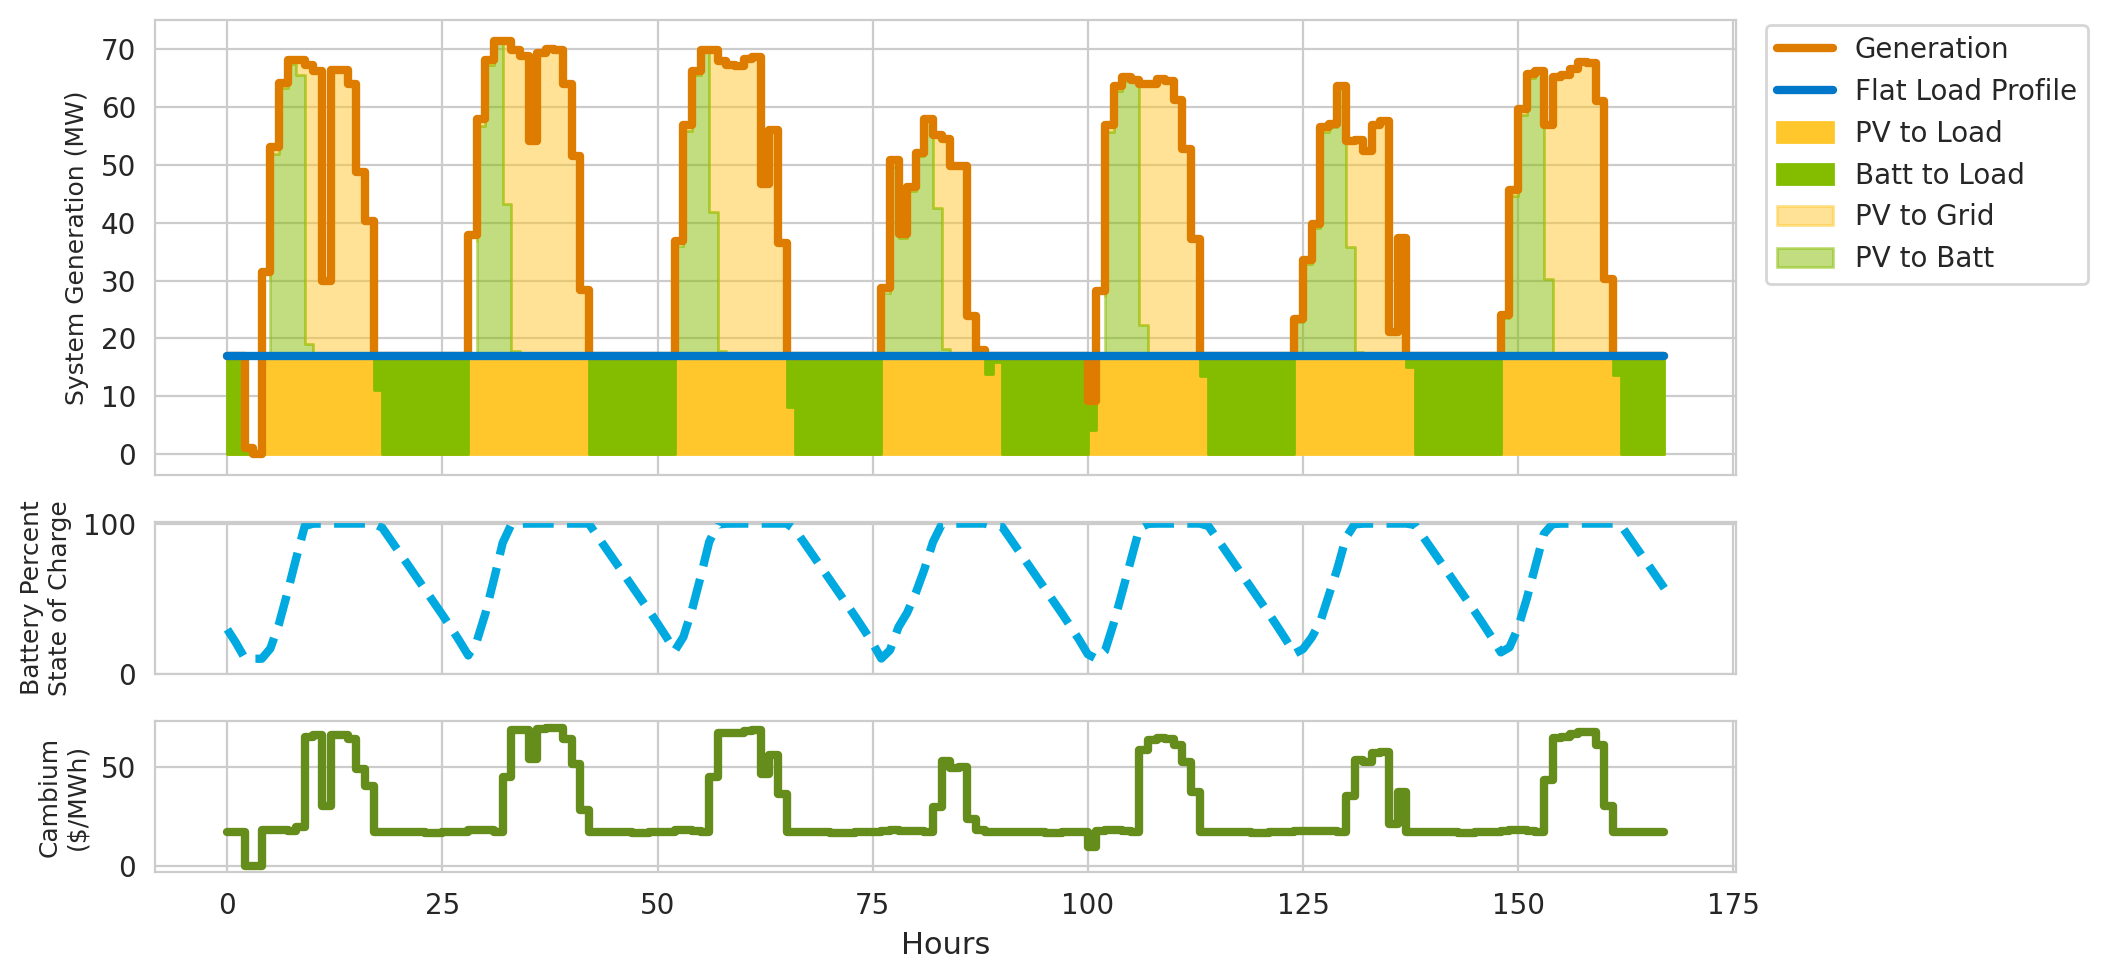

In [20]:
from matplotlib import gridspec
import seaborn as sns

sns.set_style('whitegrid')

batt_ts = pd.DataFrame({
    'load':batt_model.load.as_array(),
    'batt_to_load':batt_model.battery.Outputs.batt_to_load[0:8760],
    'pv_to_batt':batt_model.battery.Outputs.pv_to_batt[0:8760],
    'pv_to_grid':batt_model.battery.Outputs.pv_to_grid[0:8760],
    'pv_to_load':batt_model.battery.Outputs.pv_to_load[0:8760],
    'gen':batt_model.generator.Outputs.gen[0:8760],
    'soc':batt_model.generator.Outputs.batt_SOC[0:8760],
    'market_profile':[i[0] for i in batt_model.market_profile[0:8760]]
})
batt_ts[['load','batt_to_load','pv_to_batt', 'pv_to_grid','pv_to_load','gen']] /= 1e3
batt_ts['self_consume'] = batt_ts['batt_to_load'] + batt_ts['pv_to_load']
batt_ts['total_gen'] = batt_ts['self_consume'] + batt_ts['pv_to_grid'] + batt_ts['pv_to_batt']

batt_ts = batt_ts[(30*24*6):(30*24*6)+(24*7)]
batt_ts.reset_index(inplace=True)

fig = plt.figure(figsize=(9,5), dpi=200)
gs = gridspec.GridSpec(3,1, height_ratios=[3,1,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

x = batt_ts.index
zeros = np.zeros_like(x)


gen = ax1.step(x, batt_ts['total_gen'], label='Generation', linewidth=3, where='pre', color=nrel_color_dict[5])
load = ax1.plot(batt_ts['load'], label='Flat Load Profile', linewidth=3, color=nrel_color_dict[0])

ax1.fill_between(x, zeros, batt_ts['pv_to_load'],
                 label='PV to Load', step='pre',
                 color=nrel_color_dict[4])

ax1.fill_between(x, batt_ts['pv_to_load'], batt_ts['self_consume'],
                 label='Batt to Load', step='pre',
                 color=nrel_color_dict[3])

ax1.fill_between(x, batt_ts['load']+batt_ts['pv_to_batt'], batt_ts['total_gen'],
                 where=(batt_ts['total_gen'] > batt_ts['load']+batt_ts['pv_to_batt']), 
                 label='PV to Grid', step='pre',
                 color=nrel_color_dict[4], alpha=0.5)

ax1.fill_between(x, batt_ts['load'], batt_ts['load']+batt_ts['pv_to_batt'],
                 where=batt_ts['total_gen'] >= batt_ts['load'],
                 label='PV to Batt', step='pre',
                 color=nrel_color_dict[3], alpha=0.5)

ax1.set_ylabel('System Generation (MW)', size=9)


ax2.plot(batt_ts['soc'], linestyle='--', linewidth=3, color=nrel_color_dict[1])
ax2.set_ylim(0,101)
ax2.set_ylabel('Battery Percent\nState of Charge', size=9)

ax3.step(x, batt_ts['market_profile'], linewidth=3, where='pre', color=nrel_color_dict[2])
ax3.set_ylabel('Cambium\n($/MWh)', size=9)
ax3.set_xlabel('Hours', size=11)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
fig.tight_layout()

ax1.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left')

# ax1_handles, ax1_labels = ax1.get_legend_handles_labels()
# ax2_handles, ax2_labels = ax2.get_legend_handles_labels()
# fig.legend(ax1_handles+ax2_handles, ax1_labels+ax2_labels, bbox_to_anchor=(0.98, 0.99), loc='upper left')



,index,load,batt_to_load,pv_to_batt,pv_to_grid,pv_to_load,gen,soc,market_profile,self_consume,total_gen
0,4320,16889.950139,16889.950139,0.0,0.0,0.0,16889.946856,29.555808,16.889947,16889.950139,16889.950139
1,4321,16889.950139,16889.950139,0.0,0.0,0.0,16875.313354,20.615738,16.875313,16889.950139,16889.950139
2,4322,16889.950139,16889.950139,0.0,0.0,0.0,16887.242438,10.645639,16.887242,16889.950139,16889.950139
3,4323,16889.950139,1116.462916,0.0,0.0,0.0,792.628636,10.000000,0.000000,1116.462916,1116.462916
4,4324,16889.950139,0.000000,0.0,0.0,0.0,-323.834280,10.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
163,4483,16889.950139,16889.950139,0.0,0.0,0.0,16889.250902,90.190483,16.889251,16889.950139,16889.950139
164,4484,16889.950139,16889.950139,0.0,0.0,0.0,16889.102204,81.925598,16.889102,16889.950139,16889.950139
165,4485,16889.950139,16889.950139,0.0,0.0,0.0,16888.898708,73.636882,16.888899,16889.950139,16889.950139
166,4486,16889.950139,16889.950139,0.0,0.0,0.0,16888.609444,65.317986,16.888609,16889.950139,16889.950139


In [5]:
batt_ts['total_gen']

0      16889.950139
1      16889.950139
2      16889.950139
3       1116.462916
4          0.000000
           ...     
163    16889.950139
164    16889.950139
165    16889.950139
166    16889.950139
167    16889.950139
Name: total_gen, Length: 168, dtype: float64

In [6]:
batt_ts[['self_consume','pv_to_grid']]

,self_consume,pv_to_grid
0,16889.950139,0.0
1,16889.950139,0.0
2,16889.950139,0.0
3,1116.462916,0.0
4,0.000000,0.0
...,...,...
163,16889.950139,0.0
164,16889.950139,0.0
165,16889.950139,0.0
166,16889.950139,0.0


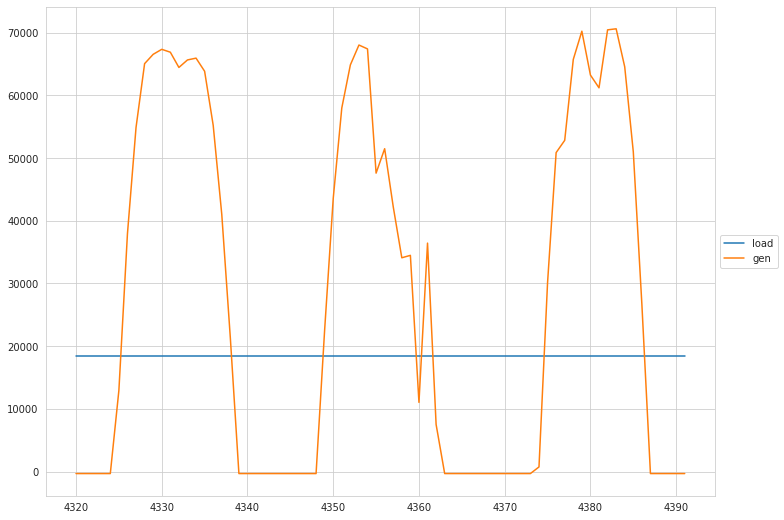

In [7]:
no_batt_system_config = {
    'SystemDesign': {
        'dc_ac_ratio': 1.2,
        'subarray1_azimuth': 180.0,
        'subarray1_tilt': 0, 
        'subarray1_track_mode': 1, 
        'system_capacity': 100000, 
        'subarray1_backtrack': 0, 
        'subarray1_nstrings': 26881, 
        'inverter_count': 1388}, 
    'BatteryTools': {
        'desired_power': 0,
        'desired_capacity': 0, 
        'desired_voltage': 500},
    'BatterySystem': {
        'en_batt': 0, 
        'no_batt_meter_position': 0
    }
}

resource_file = 'data/PySAM Downloaded Weather Files/-89.578_39.394_psm3_60_tmy.csv'

no_batt_model = PVMerchantPlant(no_batt_system_config, resource_file, cambium, 'western')
no_batt_model.execute_all()

no_batt_ts = pd.DataFrame({
    'load':no_batt_model.load.as_array(),
    'gen':no_batt_model.generator.Outputs.gen[8760:8760*2]
})

fig, ax = plt.subplots(figsize=(12,9))
no_batt_ts[24*180:(24*180)+(24*3)].plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

